In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import numpy as np
import statistics as stats
import sklearn
import re
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)



%matplotlib inline

In [2]:
# Get the csv

df = pd.read_csv('fifa21_train.csv')


In [3]:
# Define a function


def preprocess(data):

    # Fix the weights (as kg)
    Weight = [] 
    for i in data['Weight']:
        Weight.append(str(i).replace('lbs' , ''))

    data['Weight'] = Weight
    data['Weight'] = data['Weight'].astype(np.number)
    data['Weight'] = data['Weight']/2.2046

    
    # Fix the heights (as cm)
    

    cmheight = []
    for item in data['Height']:
        item = str(item).replace('\"', '')
        feetinches = item.split('\'')
        cmheight.append(round(int(feetinches[0]) * 30.48) + int(feetinches[1]) * 2.54)
    data['Height'] = cmheight
        
    # Remove the stars from columns 'IR', 'W/F', and 'SM'
    newvalues = []
    for item in data['IR']:
        item = str(item).replace('★', '')
        item = item.strip()
        newvalues.append(int(item))
    data['IR']=newvalues
  
    newvalues = []
    for item in data['W/F']:
        item = str(item).replace('★', '')
        item = item.strip()
        newvalues.append(int(item))
    data['W/F']=newvalues
    
    newvalues = []
    for item in data['SM']:
        item = str(item).replace('★', '')
        item = item.strip()
        newvalues.append(int(item))
    data['SM']=newvalues
    
  
    # Transform the 'Contract' column to only give the end date of the contract 
    contractend = []
    for item in data['Contract']:
        if 'Free' in item:
            contractend.append('DELETE')
        else:
            item = item.replace(' On Loan', '')
            item = item[-4:]
            contractend.append(int(item))
        
    data['Contract']=contractend

    # Transform the 'loan date end' column to an on loan (yes/no) column
    data['Loan Date End'] = data['Loan Date End'].fillna(0)

    loanyesno = []
    for item in data['Loan Date End']:
        if item == 0:
            loanyesno.append(item)
        else: 
            loanyesno.append(1)

    data['Loan Date End'] = loanyesno
    data = data.rename(columns={'Loan Date End':'On Loan'})

    data['On Loan']
    
    # Remove the plusses and minuses on the last few rows   
    toclean = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GK']

    superlist = []

    for column in toclean: 
        values = []
        for item in data[column]:
            if item[1] == '-' or item[1] == '+':
                values.append(int(item[0]))
            else: 
                values.append(int(item[:2]))
        superlist.append(values)


    for i in range(len(toclean)):
        data[toclean[i]] = superlist[i]

    # Clean up currency cells by removing € sign and converting 'M' and 'K' to numbers
    
    newvalues1 = []
    for item in data['Value']:
        item = item.replace('€', '')
        if 'K' in item: 
            item = float(item.replace('K', ''))
            item = item * 1000
            newvalues1.append(int(item))
        elif 'M' in item: 
            item = float(item.replace('M', ''))
            item = item * 1000000      
            newvalues1.append(int(item))
        else: 
            item = int(item)
            newvalues1.append(int(item))
    data['Value']=newvalues1
    
    
    newvalues2 = []
    for item in data['Wage']:
        item = item.replace('€', '')
        if 'K' in item: 
            item = float(item.replace('K', ''))
            item *= 1000
            newvalues2.append(int(item))
        elif 'M' in item: 
            item = float(item.replace('M', ''))
            item *= 1000000      
            newvalues2.append(int(item))
        else: 
            item = int(item)
            newvalues2.append(int(item))
    data['Wage']=newvalues2
    
    
    newvalues3 = []
    for item in data['Release Clause']:
        item = item.replace('€', '')
        if 'K' in item: 
            item = float(item.replace('K', ''))
            item *= 1000
            newvalues3.append(int(item))
        elif 'M' in item: 
            item = float(item.replace('M', ''))
            item *= 1000000      
            newvalues3.append(int(item))
        else: 
            item = int(item)
            newvalues3.append(int(item))
    data['Release Clause']=newvalues3
    
    
    # Clean up Hits column (which contains some values with K in them)¶
    newhits = []
    for item in data['Hits']:
        if 'K' in item:
            item = item.replace('K','')
            item = float(item) * 1000
            newhits.append(int(item))
        else: 
            newhits.append(int(item))
    data['Hits'] = newhits

    # Dropping stuff
    
    # Drop columns with irrelevant attributes
    #Some atributes are used to calculate the rating per category, that we already have, so individual attributes are not necessary here

    data = data.drop(['Club','Team & Contract', 'Position', 'ID','Growth','Joined', 'Contract','Name','Crossing','Finishing','Heading Accuracy','Short Passing','Volleys',
           'Dribbling','Curve','FK Accuracy','Long Passing','Ball Control',
           'Acceleration','Sprint Speed','Agility','Reactions','Balance',
          'Shot Power','Jumping','Stamina','Strength','Long Shots',
          'Aggression','Interceptions','Positioning','Vision','Penalties','Composure',
          'Marking','Standing Tackle','Sliding Tackle',
          'GK Diving','GK Handling','GK Kicking','GK Positioning','GK Reflexes'], axis=1)
    

    #Drop the rows with less than 5% of NaN
    data = data[data['A/W'].isna()==False]
    data = data[data['D/W'].isna()==False]
    
    return data

data = preprocess(df)

KeyError: 'Club'

In [ ]:
y = data['OVA']

X = data.drop(['OVA'], axis = 1)

In [14]:
X_num = data.select_dtypes(np.number)
X_cat = data.select_dtypes(object)

In [7]:
X_num.head(50)

,Age,Height,Weight,On Loan,Value,Wage,Release Clause,Attacking,Skill,Movement,Power,Mentality,Defending,Goalkeeping,Total Stats,Base Stats,W/F,SM,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,OVA
0,26,174.86,73.029121,0,525000,4000,801000,258,286,346,306,290,148,48,1682,357,4,2,1,69,51,63,63,51,60,3,58,58,58,61,62,62,62,61,63,63,63,63,63,63,63,63,59,59,59,59,59,58,54,54,54,58,15,64
1,30,183.00,72.121927,1,8500000,23000,0,365,375,404,372,313,77,55,1961,412,3,4,2,83,75,68,82,33,71,44,77,77,77,77,77,77,77,77,76,76,76,76,68,68,68,76,57,53,53,53,57,53,48,48,48,53,18,77
2,33,162.16,60.782001,0,9000000,49000,15300000,336,424,424,308,332,80,21,1925,404,4,4,2,80,77,78,86,27,56,73,73,73,73,80,79,79,79,80,80,80,80,79,74,74,74,79,59,56,56,56,59,53,41,41,41,53,12,80
3,22,177.40,68.946748,0,275000,4000,694000,242,259,282,277,257,168,42,1527,329,2,2,1,57,44,54,57,57,60,7,50,50,50,51,51,51,51,51,53,53,53,53,56,56,56,53,56,58,58,58,56,57,58,58,58,57,14,59
4,23,179.94,68.039554,0,725000,2000,1400000,249,280,324,280,294,185,52,1664,360,2,3,1,66,44,60,64,60,66,4,56,56,56,59,59,59,59,59,61,61,61,62,63,63,63,62,64,64,64,64,64,63,61,61,61,63,15,65
5,33,177.40,69.853942,0,1400000,11000,2200000,328,333,358,321,300,103,65,1808,379,4,3,1,74,63,70,71,37,64,6,67,67,67,70,69,69,69,70,70,70,70,70,66,66,66,70,58,55,55,55,58,55,49,49,49,55,19,71
6,30,183.00,69.853942,0,6000000,28000,10800000,325,316,361,329,318,235,39,1923,410,5,3,2,67,58,67,73,77,68,49,66,66,66,68,67,67,67,68,68,68,68,69,70,70,70,69,74,74,74,74,74,74,74,74,74,74,15,76
7,22,177.40,73.029121,0,300000,800,540000,262,273,323,240,245,129,51,1523,327,2,2,1,62,48,63,60,42,52,4,55,55,55,59,58,58,58,59,60,60,60,61,59,59,59,61,52,52,52,52,52,50,46,46,46,50,15,60
8,34,193.16,87.090629,0,210000,2000,305000,277,281,200,343,294,192,49,1636,338,2,2,1,34,50,58,55,65,76,4,57,57,57,54,56,56,56,54,56,56,56,55,61,61,61,55,59,64,64,64,59,60,68,68,68,60,16,65
9,35,183.00,73.936315,0,220000,4000,319000,306,270,299,346,329,205,54,1809,381,3,3,1,54,62,63,64,68,70,3,62,62,62,63,62,62,62,63,63,63,63,62,64,64,64,62,65,66,66,66,65,65,68,68,68,65,16,67


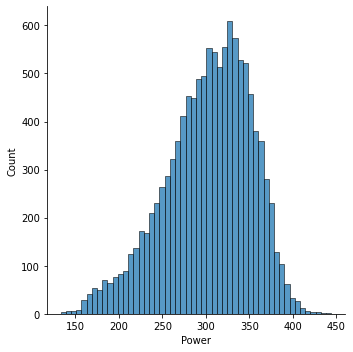

In [8]:
sns.displot(X_num['Power'])
plt.show()

In [9]:
transformer = MinMaxScaler().fit(X_num)
x_normalized = transformer.transform(X_num)
X_normal = pd.DataFrame(x_normalized, columns=X_num.columns)

X_normal

,Age,Height,Weight,On Loan,Value,Wage,Release Clause,Attacking,Skill,Movement,Power,Mentality,Defending,Goalkeeping,Total Stats,Base Stats,W/F,SM,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,OVA
0,0.370370,0.395947,0.349206,0.0,0.005833,0.007143,0.004811,0.546835,0.569087,0.663818,0.556270,0.654596,0.518219,0.084309,0.604577,0.492366,0.75,0.25,0.00,0.614286,0.447368,0.558824,0.522388,0.506494,0.515625,0.000000,0.565789,0.565789,0.565789,0.602564,0.602564,0.602564,0.602564,0.602564,0.610390,0.610390,0.610390,0.631579,0.643836,0.643836,0.643836,0.631579,0.642857,0.614286,0.614286,0.614286,0.642857,0.637681,0.527778,0.527778,0.527778,0.637681,0.075949,0.395833
1,0.518519,0.554560,0.333333,1.0,0.094444,0.041071,0.000000,0.817722,0.777518,0.829060,0.768489,0.718663,0.230769,0.100703,0.781945,0.702290,0.50,0.75,0.25,0.814286,0.763158,0.632353,0.805970,0.272727,0.687500,0.004458,0.815789,0.815789,0.815789,0.807692,0.794872,0.794872,0.794872,0.807692,0.779221,0.779221,0.779221,0.802632,0.712329,0.712329,0.712329,0.802632,0.614286,0.528571,0.528571,0.528571,0.614286,0.565217,0.444444,0.444444,0.444444,0.565217,0.113924,0.666667
2,0.629630,0.148480,0.134921,0.0,0.100000,0.087500,0.091892,0.744304,0.892272,0.886040,0.562701,0.771588,0.242915,0.021077,0.759059,0.671756,0.75,0.75,0.25,0.771429,0.789474,0.779412,0.865672,0.194805,0.453125,0.007611,0.763158,0.763158,0.763158,0.846154,0.820513,0.820513,0.820513,0.846154,0.831169,0.831169,0.831169,0.842105,0.794521,0.794521,0.794521,0.842105,0.642857,0.571429,0.571429,0.571429,0.642857,0.565217,0.347222,0.347222,0.347222,0.565217,0.037975,0.729167
3,0.222222,0.445440,0.277778,0.0,0.003056,0.007143,0.004168,0.506329,0.505855,0.481481,0.463023,0.562674,0.599190,0.070258,0.506039,0.385496,0.25,0.25,0.00,0.442857,0.355263,0.426471,0.432836,0.584416,0.515625,0.000435,0.460526,0.460526,0.460526,0.474359,0.461538,0.461538,0.461538,0.474359,0.480519,0.480519,0.480519,0.500000,0.547945,0.547945,0.547945,0.500000,0.600000,0.600000,0.600000,0.600000,0.600000,0.623188,0.583333,0.583333,0.583333,0.623188,0.063291,0.291667
4,0.259259,0.494934,0.261905,0.0,0.008056,0.003571,0.008408,0.524051,0.555035,0.601140,0.472669,0.665738,0.668016,0.093677,0.593134,0.503817,0.25,0.50,0.00,0.571429,0.355263,0.514706,0.537313,0.623377,0.609375,0.000109,0.539474,0.539474,0.539474,0.576923,0.564103,0.564103,0.564103,0.576923,0.584416,0.584416,0.584416,0.618421,0.643836,0.643836,0.643836,0.618421,0.714286,0.685714,0.685714,0.685714,0.714286,0.710145,0.625000,0.625000,0.625000,0.710145,0.075949,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11623,0.481481,0.296960,0.293651,0.0,0.006111,0.000893,0.007207,0.627848,0.562061,0.726496,0.546624,0.554318,0.242915,0.112412,0.576605,0.416031,0.50,0.50,0.00,0.571429,0.671053,0.323529,0.567164,0.272727,0.468750,0.000109,0.657895,0.657895,0.657895,0.602564,0.615385,0.615385,0.615385,0.602564,0.571429,0.571429,0.571429,0.565789,0.506849,0.506849,0.506849,0.565789,0.457143,0.414286,0.414286,0.414286,0.457143,0.434783,0.375000,0.375000,0.375000,0.434783,0.126582,0.416667
11624,0.333333,0.604053,0.404762,0.0,0.006944,0.005357,0.005351,0.460759,0.480094,0.626781,0.450161,0.587744,0.663968,0.114754,0.545455,0.454198,0.50,0.25,0.00,0.700000,0.144737,0.455882,0.462687,0.623377,0.656250,0.000000,0.434211,0.434211,0.434211,0.525641,0.474359,0.474359,0.474359,0.525641,0.493506,0.493506,0.493506,0.565789,0.547945,0.547945,0.547945,0.565789,0.700000,0.628571,0.628571,0.628571,0.700000,0.710145,0.625000,0.625000,0.625000,0.710145,0.088608,0.416667
11625,0.407407,0.604053,0.452381,0.0,0.017778,0.007143,0.017417,0.106329,0.124122,0.353276,0.270096,0.128134,0.085020,0.784543,0.249205,0.606870,0.25,0.00,0.00,0.657143,0.657895,0.602941,0.656716,0.36

In [10]:
for column in X_cat.columns:
   print(str(column), ': ' , len(X_cat[column].unique()))

Nationality :  159
Club :  879
BP :  15
foot :  2
A/W :  3
D/W :  3
